# Mock Default dataset by CTAB-GAN-PLUS
### ***Introduction***
CTAB-GAN+ is a conditional GAN based tabular data generator. CTAB-GAN+ advances beyond SOTA methods by improving performance on regression datasets and allowing control over the quality of synthesized data. The core features ofCTAB-GAN+ include as follows:    
- (1) introduction of the auxiliary component, i.e., classifier or regressor, into conditional GAN;    
- (2) effective data encodings for mixed and simple Guassian variables;    
- (3) a novel construction of conditional vectors;    
- (4) tailored DP discriminator for tabular GAN.     

This dataset is aimed at the case of customers' default payments in Taiwan, which is used to get predictive accuracy of probability of default.            
### ***Our work***   
We use CTAB-GAN+ to simulate Default data and visualize real and fake data. See code, comments, and diagrams for details.             
### ***Reference:***
[1] I. Yeh (2009). Default of Credit Card Clients [Dataset]. UCI Machine Learning Repository. Available: http://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients       
[2] Z. Zhao, A. Kunar, R. Birke, H. Van der Scheer, and L. Y. Chen, “CTAB-GAN+: Enhancing Tabular Data Synthesis,” Frontiers in big Data, vol. 6, p. 1296508, 2024.

***Time ： 2024/11/27 17:50***  
***Author ： Chuang Liu***  
***Email ：LIUC0316@126.COM***  
***File ：Default_Mocking_Plus.ipynb***  
***Notebook ：Jupyter***   

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CTAB-GAN-Plus/CTAB-GAN-Plus')

In [3]:
import torch
print(torch.cuda.is_available())
!nvidia-smi

True
Wed Nov 27 05:13:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

In [4]:
!pip install dython
# Importing the model
from model.ctabgan import CTABGAN
# Importing the evaluation metrics
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics
# Importing standard libraries
import numpy as np
import pandas as pd
import glob

In [5]:
# Specifying the replication number
num_exp = 1
# Specifying the name of the dataset used
dataset = "Default"
# Specifying the path of the dataset used
real_path = "drive/MyDrive/Colab Notebooks/CTAB-GAN-Plus/CTAB-GAN-Plus/Real_Datasets/Default/Default.csv"
# Specifying the root directory for storing generated data
fake_file_root = "drive/MyDrive/Colab Notebooks/CTAB-GAN-Plus/CTAB-GAN-Plus/Fake_Datasets"

In [6]:
# Initializing the synthesizer object and specifying input parameters
# Notice: If you have continuous variable, you do not need to explicitly assign it. It will be treated like
# that by default
synthesizer =  CTABGAN(raw_csv_path = real_path,
                 test_ratio = 0.20,
                 categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default payment next month'],
                 log_columns = [],
                 mixed_columns= {'BILL_AMT1':[0.0],'BILL_AMT2':[0.0],'BILL_AMT3':[0.0],'BILL_AMT4':[0.0],'BILL_AMT5':[0.0],'BILL_AMT6':[0.0], 'PAY_AMT1':[0.0],'PAY_AMT2':[0.0],'PAY_AMT3':[0.0],'PAY_AMT4':[0.0],'PAY_AMT5':[0.0],'PAY_AMT6':[0.0]},
                 general_columns = ["AGE"],
                 non_categorical_columns = [],
                 integer_columns = ['LIMIT_BAL', 'AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6', 'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'],
                 problem_type= {"Classification": 'default payment next month'})

# Fitting the synthesizer to the training dataset and generating synthetic data
synthesizer.fit()

100%|██████████| 150/150 [1:20:53<00:00, 32.36s/it]

Finished training in 4920.897665262222  seconds.


In [7]:
for i in range(num_exp):
    syn = synthesizer.generate_samples()
    syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

In [8]:
# Collecting the paths to all corresponding generated datasets for evaluation
fake_paths = glob.glob(fake_file_root+"/"+dataset+"/"+"*")

In [9]:
# Specifying the list of classifiers to conduct ML utility evaluation
model_dict =  {"Classification":["lr","dt","rf","mlp","svm"]}
result_mat = get_utility_metrics(real_path,fake_paths,"MinMax",model_dict, test_ratio = 0.20)

# Storing and presenting the results as a dataframe
result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = list(model_dict.values())[0]
result_df

,Acc,AUC,F1_Score
lr,-0.050000,0.006570,-0.034892
dt,21.516667,0.062420,0.128239
rf,0.350000,0.036109,-0.014788
mlp,1.500000,0.039514,0.001320
svm,1.016667,0.005597,-0.005944


In [10]:
# Specifying the categorical columns of the dataset used
adult_categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']

# Storing and presenting the results as a dataframe
stat_res_avg = []
for fake_path in fake_paths:
    stat_res = stat_sim(real_path,fake_path,adult_categorical)
    stat_res_avg.append(stat_res)

stat_columns = ["Average WD (Continuous Columns","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res_avg).mean(axis=0).reshape(1,3),columns=stat_columns)
stat_results

column:  LIMIT_BAL WD:  0.013219986430976428
column:  SEX WD:  0.030666666666666675
column:  EDUCATION WD:  0.007866666666666662
column:  MARRIAGE WD:  0.03393333333333333
column:  AGE WD:  0.062429310344827585
column:  PAY_0 WD:  0.013870000000000016
column:  PAY_2 WD:  0.012729999999999995
column:  PAY_3 WD:  0.004456666666666672
column:  PAY_4 WD:  0.007493333333333343
column:  PAY_5 WD:  0.003353333333333336
column:  PAY_6 WD:  0.010916666666666675
column:  BILL_AMT1 WD:  0.003074800436425029
column:  BILL_AMT2 WD:  0.010530926879173355
column:  BILL_AMT3 WD:  0.003320920692840249
column:  BILL_AMT4 WD:  0.0041291320722014035
column:  BILL_AMT5 WD:  0.008956020115583628
column:  BILL_AMT6 WD:  0.004010475354660752
column:  PAY_AMT1 WD:  0.0015247096910086587
column:  PAY_AMT2 WD:  0.0005785359615118492
column:  PAY_AMT3 WD:  0.0008852958201270751
column:  PAY_AMT4 WD:  0.0008473443370907072
column:  PAY_AMT5 WD:  0.0017802300273447608
column:  PAY_AMT6 WD:  0.0010394251442940002
co

,Average WD (Continuous Columns,Average JSD (Categorical Columns),Correlation Distance
0,0.012139,NaN,1.275599


In [11]:
# Storing and presenting the results as a dataframe
priv_res_avg = []
for fake_path in fake_paths:
    priv_res = privacy_metrics(real_path,fake_path)
    priv_res_avg.append(priv_res)

privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res_avg).mean(axis=0).reshape(1,6),columns=privacy_columns)
privacy_results

,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,0.563865,0.29328,0.49419,0.652668,0.503214,0.612032


In [12]:
# Storing generated data for future use if needed
# syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

In [14]:
from table_evaluator import TableEvaluator

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

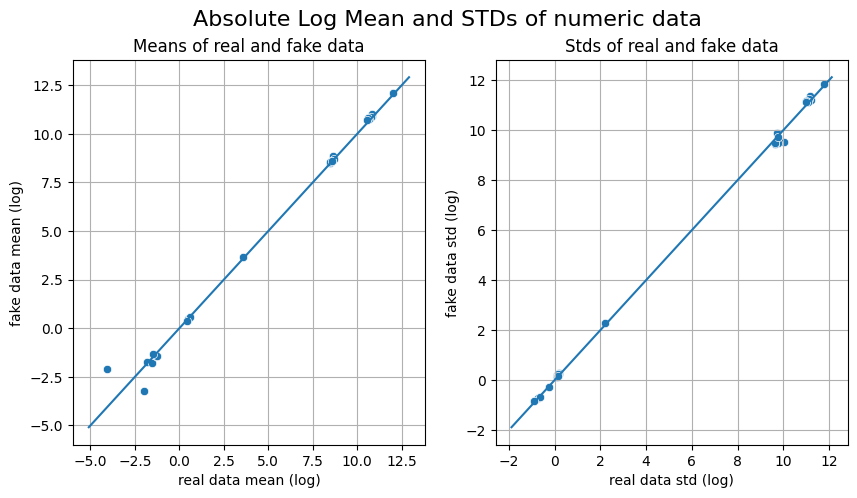

Error while plotting column LIMIT_BAL


TypeError: cdf() got an unexpected keyword argument 'local_ax'

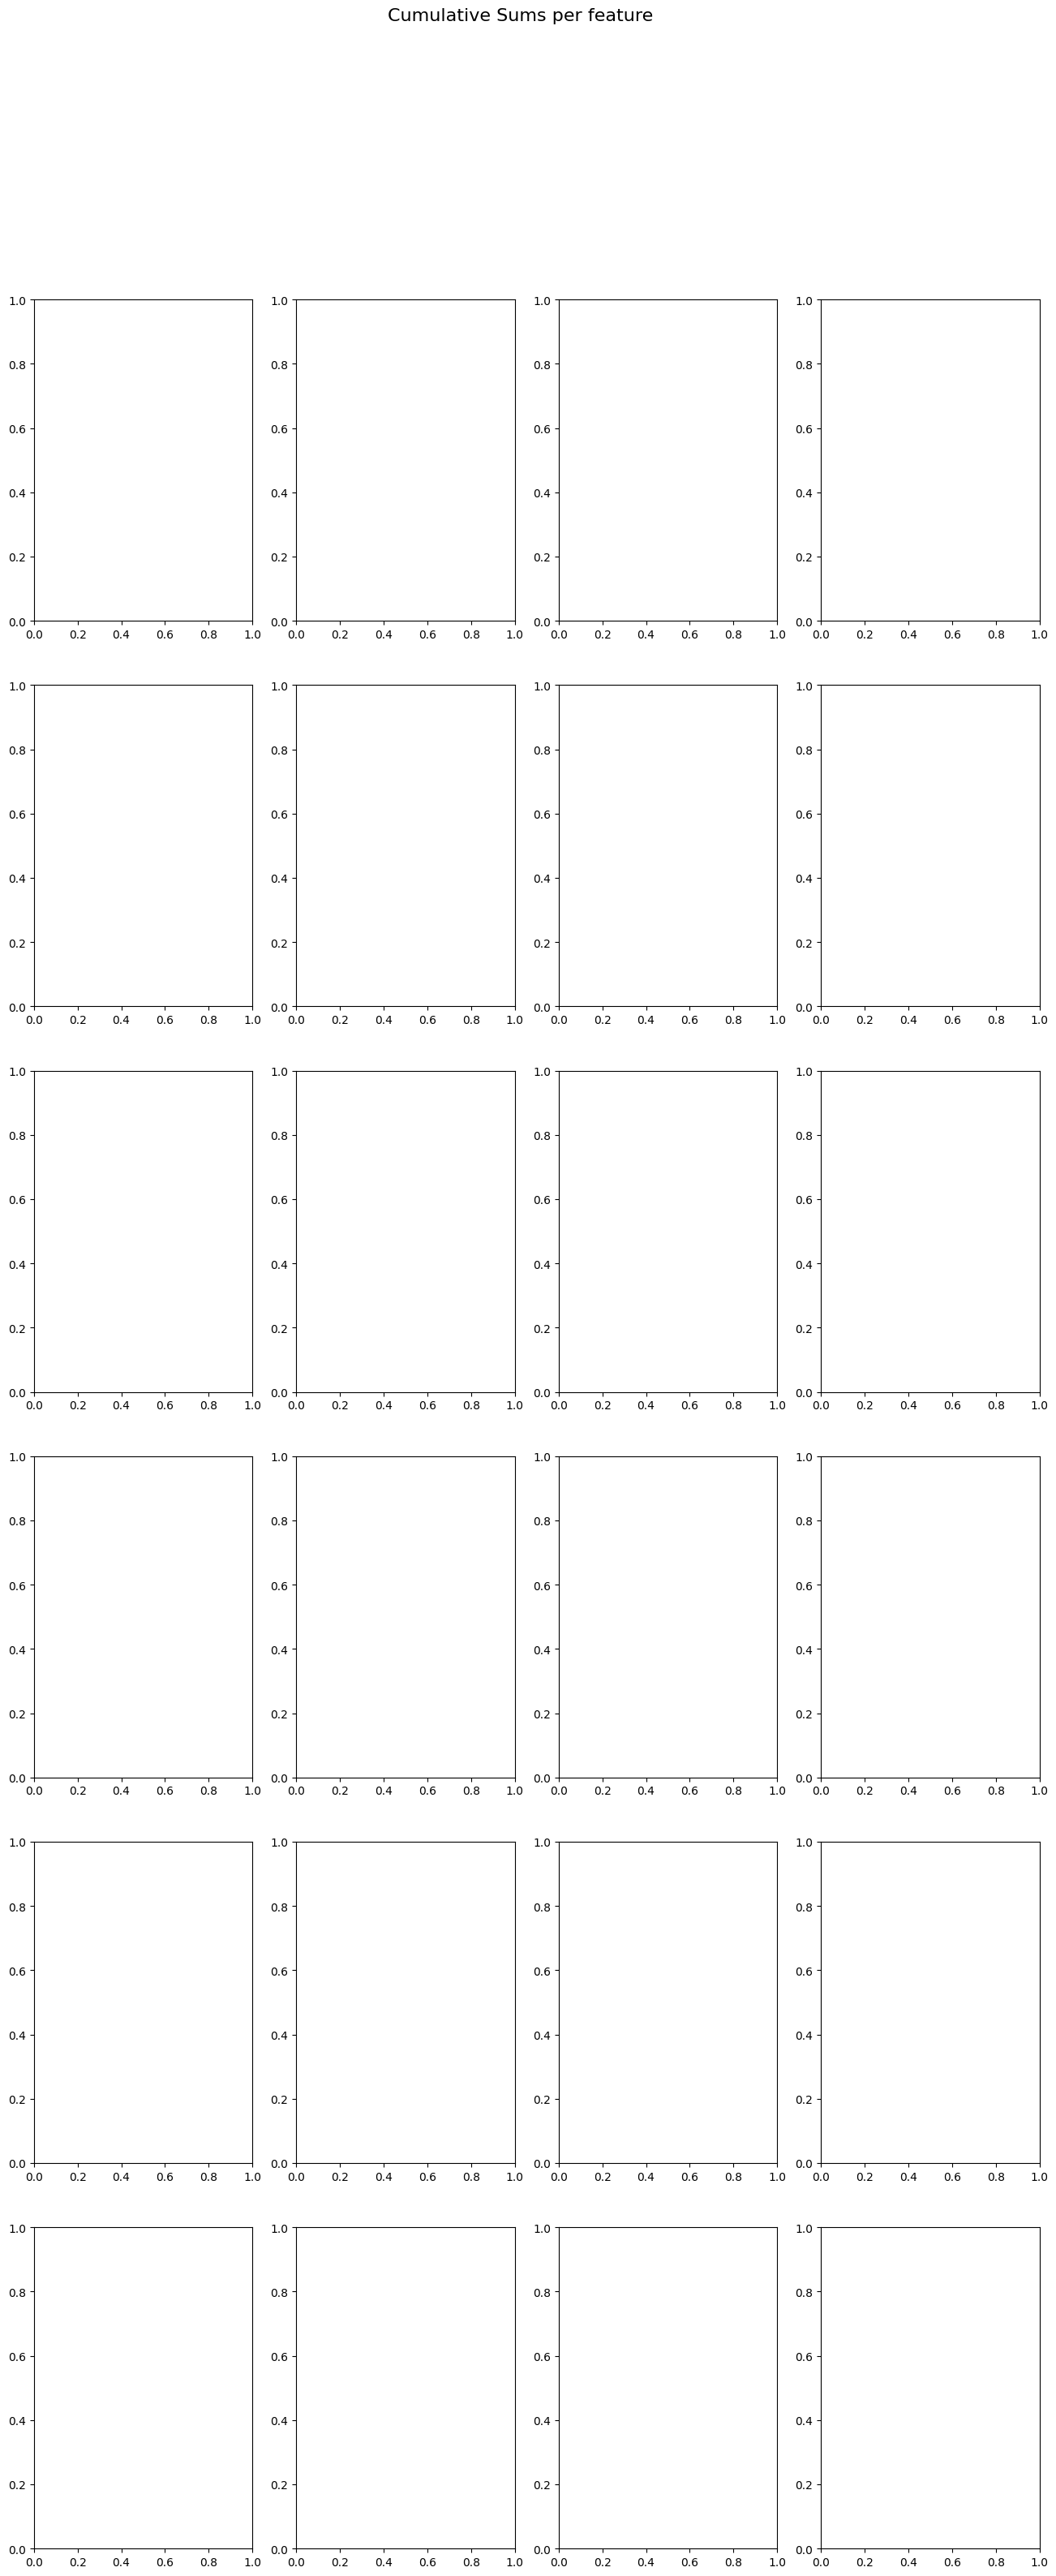

In [15]:
!pip install scipy==1.11.4
Real_Dataset = pd.read_csv('drive/MyDrive/Colab Notebooks/CTAB-GAN-Plus/CTAB-GAN-Plus/Real_Datasets/Default/Default.csv')
Fake_Dataset = pd.read_csv('drive/MyDrive/Colab Notebooks/CTAB-GAN-Plus/CTAB-GAN-Plus/Fake_Datasets/Default/Default_fake_0.csv')

Real_Dataset.head()
Real_Dataset.info()
Fake_Dataset.head()
Fake_Dataset.info()

print(Real_Dataset.shape, Fake_Dataset.shape)
table_evaluator = TableEvaluator(Real_Dataset, Fake_Dataset)

table_evaluator.visual_evaluation()